# XGBoost: First Model and Feature Importance

In this notebook, we'll build the first of two baseline models: an XGBoost model for each player trained on 2010 and 2011, with 2012 as the test set.

We'll then construct Shapley values to get a more intuitive sense of the most important features. Because of the high dimensionality of the data, we'll want our model to be very conservative.

Note that I'm running the xgboost package on SageMaker because I have issues installing it locally. But this section should be done locally by most users.

In [1]:
!conda install -y -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    py-xgboost-0.90            |           py36_4          73 KB  conda-forge
    xgboost-0.90               |   py36he1b5a44_4          11 KB  conda-forge
    mkl_random-1.0.2           |           py36_0         1.3 MB  conda-forge
    libxgboost-0.90            |       he1b5a44_4         2.4 MB  conda-forge
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    tbb-2019.9                 |       hc9558a2_0    

In [2]:
!conda install -y -c conda-forge shap

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tqdm-4.36.1                |             py_0          43 KB  conda-forge
    shap-0.31.0                |   py36hb3f55d8_0         369 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         412 KB

The following NEW packages will be INSTALLED:

    shap: 0.31.0-py36hb3f55d8_0 conda-forge
    tqdm: 4.36.1-py_0           conda-forge


tqdm-4.36.1          | 43 KB     | ##################################### | 100% 
shap-0.31.0        

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

plt.style.use('ggplot')

In [32]:
brady = pd.read_csv('../data/data_final/final/features_raw/brady.csv')
X, y = brady.iloc[:,1:], brady.iloc[:,0]

In [33]:
X_train, X_test, y_train, y_test = X.iloc[:32,:], X.iloc[32:,:], y.iloc[:32], y.iloc[32:]
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [34]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 10, n_estimators = 30)

In [35]:
xg_reg.fit(X_train,y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=30,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [36]:
preds = xg_reg.predict(X_test)

In [37]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
print("RMSE: {:.2f}\n MAE: {:.2f}".format(rmse, mae))

RMSE: 7.72
 MAE: 6.14


Text(0.5, 1.0, 'Tom Brady Fantasy Points 2012, Predicted vs Actual')

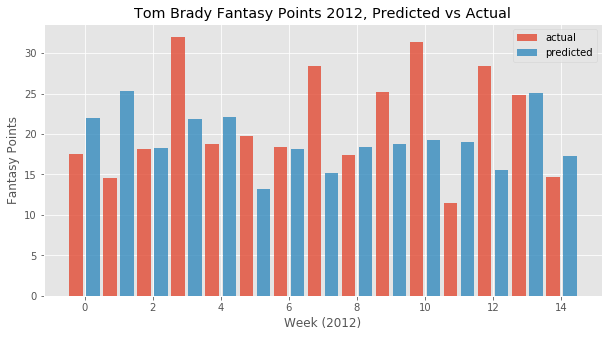

In [38]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
bar1 = ax.bar(x = np.arange(0, len(y_test)) - .25, height=y_test, width=.4, alpha = 0.8, label='actual')
bar2 = ax.bar(x = np.arange(0, len(preds)) + .25, height=preds, width=.4, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual')

In [39]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.25,'learning_rate': 0.1,
                'max_depth': 2, 'alpha': 10}

cv_results_rmse = xgb.cv(dtrain=dtrain, params=params, nfold=5,
                    num_boost_round=100,early_stopping_rounds=20, metrics="rmse", as_pandas=True, seed=123)
cv_results_mae = xgb.cv(dtrain=dtrain, params=params, nfold=5,
                    num_boost_round=100,early_stopping_rounds=20, metrics="mae", as_pandas=True, seed=123)

In [40]:
print(cv_results_rmse.tail(1))
print(cv_results_mae.tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
28         3.613297        0.164271        7.230763       2.593521
    train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
24        2.876216       0.173401       6.417494      2.249628


In [41]:
xg_reg2 = xgb.train(params=params, dtrain=dtrain, num_boost_round=100)

In [42]:
preds2 = xg_reg2.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, preds2))
mae = mean_absolute_error(y_test, preds2)
print("RMSE: {:.2f}\n MAE: {:.2f}".format(rmse, mae))

RMSE: 7.63
 MAE: 6.28


Text(0.5, 1.0, 'Tom Brady Fantasy Points 2012, Predicted vs Actual (Model 2)')

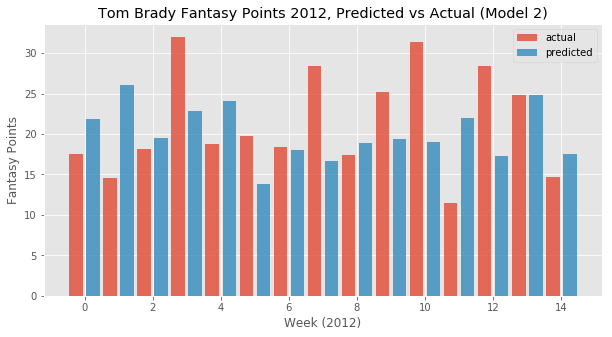

In [43]:
fig, ax = plt.subplots()
bar1 = ax.bar(x = np.arange(0, len(y_test)) - .25, height=y_test, width=.4, alpha = 0.8, label='actual')
bar2 = ax.bar(x = np.arange(0, len(preds2)) + .25, height=preds2, width=.4, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual (Model 2)')

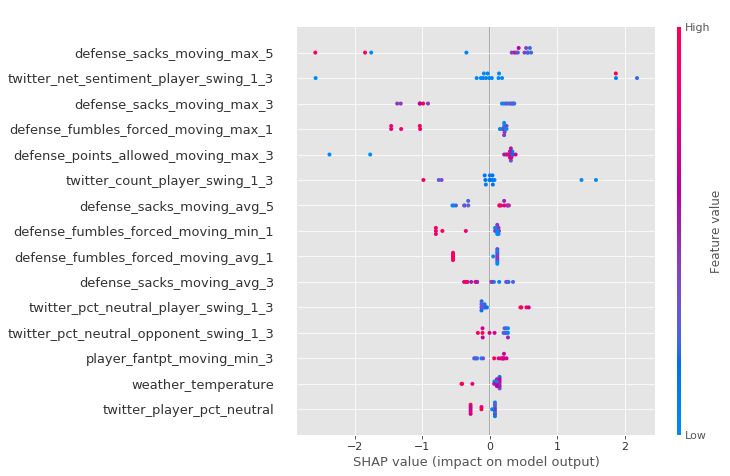

In [47]:
shap.summary_plot(
    shap.TreeExplainer(xg_reg).shap_values(X_test), 
    features = X_test,
    feature_names = X_train.columns, 
    max_display=15
)

The similarity of shap values for the defensive stats makes me think PCA would be really good here. It suggests that there may be a good amount of overlap between those features.

In [48]:
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X_test)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[7], X_test.iloc[7])

Finally, try iteratively training new models after each game to see how it improves prediciton accuracy. Use xg_reg as a baseline.

In [49]:
X_train_iter = X_train
y_train_iter = y_train
preds = []

for game_idx in np.arange(0, len(X_test)):
    xg_reg.fit(X_train_iter, y_train_iter)
    preds.append(xg_reg.predict(X_test)[game_idx])
    X_train_iter = X_train_iter.append(pd.Series(X_test.iloc[game_idx]))
    y_train_iter = y_train_iter.append(pd.Series(y_test.iloc[game_idx]))


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [50]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
print("RMSE: {:.2f}\n MAE: {:.2f}".format(rmse, mae))

RMSE: 6.83
 MAE: 5.44


Text(0.5, 1.0, 'Tom Brady Fantasy Points 2012, Predicted vs Actual (Model 3 - Iterative Training)')

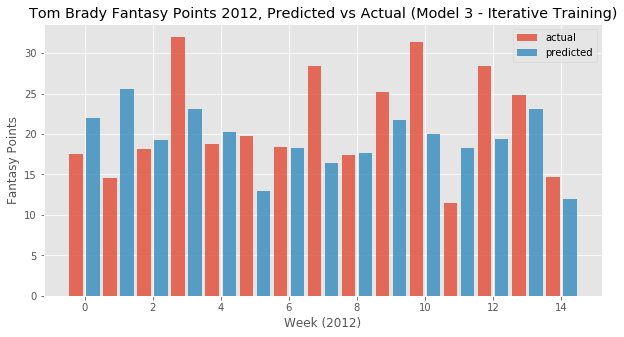

In [51]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
bar1 = ax.bar(x = np.arange(0, len(y_test)) - .25, height=y_test, width=.4, alpha = 0.8, label='actual')
bar2 = ax.bar(x = np.arange(0, len(preds)) + .25, height=preds, width=.4, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual (Model 3 - Iterative Training)')

# McCoy

In [52]:
mccoy = pd.read_csv('../data/data_final/final/features_raw/mccoy.csv')
X, y = mccoy.iloc[:,1:], mccoy.iloc[:,0]

In [53]:
X_train, X_test, y_train, y_test = X.iloc[:30,:], X.iloc[30:,:], y.iloc[:30], y.iloc[30:]
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [54]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 10, n_estimators = 30)

In [55]:
xg_reg.fit(X_train,y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=30,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [56]:
preds = xg_reg.predict(X_test)

In [57]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
print("RMSE: {:.2f}\n MAE: {:.2f}".format(rmse, mae))

RMSE: 5.83
 MAE: 5.03


Text(0.5, 1.0, 'LeSean McCoy Fantasy Points 2012, Predicted vs Actual')

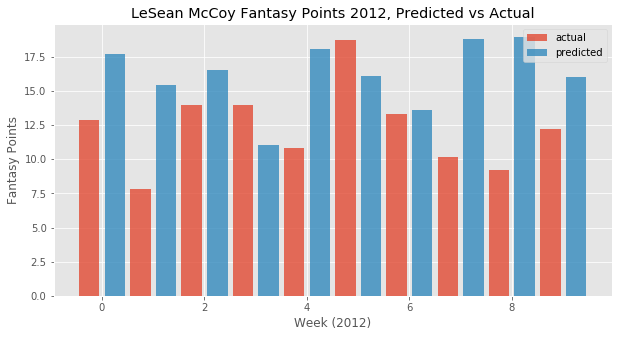

In [58]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
bar1 = ax.bar(x = np.arange(0, len(y_test)) - .25, height=y_test, width=.4, alpha = 0.8, label='actual')
bar2 = ax.bar(x = np.arange(0, len(preds)) + .25, height=preds, width=.4, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('LeSean McCoy Fantasy Points 2012, Predicted vs Actual')

In [59]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.25,'learning_rate': 0.6,
                'max_depth': 2, 'alpha': 50}

cv_results_rmse = xgb.cv(dtrain=dtrain, params=params, nfold=5,
                    num_boost_round=100,early_stopping_rounds=20, metrics="rmse", as_pandas=True, seed=123)
cv_results_mae = xgb.cv(dtrain=dtrain, params=params, nfold=5,
                    num_boost_round=100,early_stopping_rounds=20, metrics="mae", as_pandas=True, seed=123)

In [60]:
print(cv_results_rmse.tail(1))
print(cv_results_mae.tail(1))

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
6         4.819311        0.163556        7.603181       1.438343
   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
6        3.407981       0.212235       6.564541      1.209255


In [61]:
xg_reg2 = xgb.train(params=params, dtrain=dtrain, num_boost_round=100)

In [62]:
preds2 = xg_reg2.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, preds2))
mae = mean_absolute_error(y_test, preds2)
print("RMSE: {:.2f}\n MAE: {:.2f}".format(rmse, mae))

RMSE: 5.74
 MAE: 4.45


Text(0.5, 1.0, 'LeSean McCoy Fantasy Points 2012, Predicted vs Actual (Model 2)')

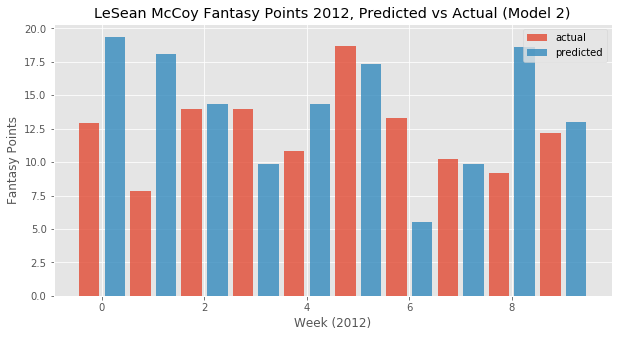

In [63]:
fig, ax = plt.subplots()
bar1 = ax.bar(x = np.arange(0, len(y_test)) - .25, height=y_test, width=.4, alpha = 0.8, label='actual')
bar2 = ax.bar(x = np.arange(0, len(preds2)) + .25, height=preds2, width=.4, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('LeSean McCoy Fantasy Points 2012, Predicted vs Actual (Model 2)')

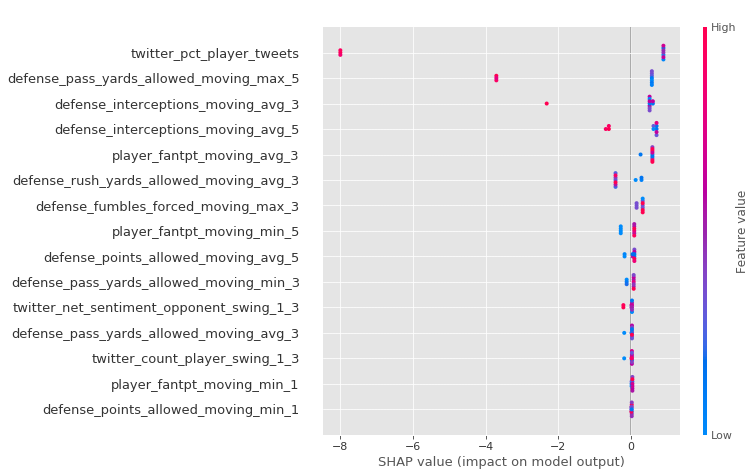

In [64]:
shap.summary_plot(
    shap.TreeExplainer(xg_reg2).shap_values(X_test), 
    features = X_test,
    feature_names = X_train.columns, 
    max_display=15
)

In [72]:
explainer = shap.TreeExplainer(xg_reg2)
shap_values = explainer.shap_values(X_test)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1], X_test.iloc[1])

In [76]:
X_train_iter = X_train
y_train_iter = y_train
preds = []

for game_idx in np.arange(0, len(X_test)):
    xg_reg.fit(X_train_iter, y_train_iter)
    preds.append(xg_reg.predict(X_test)[game_idx])
    X_train_iter = X_train_iter.append(pd.Series(X_test.iloc[game_idx]))
    y_train_iter = y_train_iter.append(pd.Series(y_test.iloc[game_idx]))


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [77]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
print("RMSE: {:.2f}\n MAE: {:.2f}".format(rmse, mae))

RMSE: 5.77
 MAE: 5.41


Text(0.5, 1.0, 'LeSean McCoy Fantasy Points 2012, Predicted vs Actual (Model 3 - Iterative Training)')

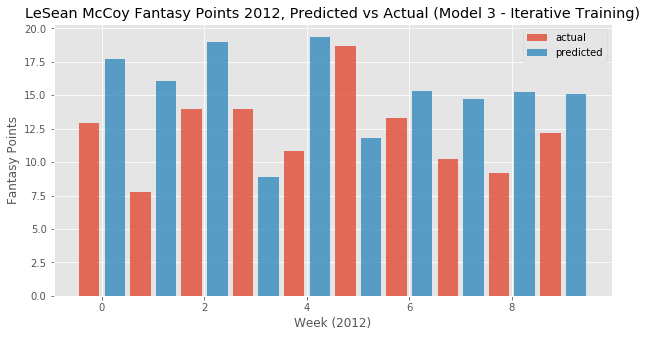

In [78]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
bar1 = ax.bar(x = np.arange(0, len(y_test)) - .25, height=y_test, width=.4, alpha = 0.8, label='actual')
bar2 = ax.bar(x = np.arange(0, len(preds)) + .25, height=preds, width=.4, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('LeSean McCoy Fantasy Points 2012, Predicted vs Actual (Model 3 - Iterative Training)')